In [108]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')
import importlib

from astroLuSt.physics import asteroseismology as alpas
from astroLuSt.physics import photometry as alpph
from astroLuSt.synthetics import images as alsi

importlib.reload(alpas)
importlib.reload(alpph)
importlib.reload(alsi)

plt.style.use('astroLuSt.styles.LuSt_style')

# Magnitudes and Fluxes

In [109]:
m,      dm     = 10, .1
m_ref,  dm_ref = 5 , .01
f_ref, df_ref  = 2 , .1
d = 20 #pc
plx = 1/d #arcsec

## Converting Magnitudes and Fluxes

In [110]:
f, df = alpph.mags2fluxes(m=m, m_ref=m_ref, f_ref=f_ref, dm=dm, dm_ref=dm_ref, df_ref=df_ref)
print(f'Flux from mags: {f:.3f} +/- {df:.3f}')
m, dm_ = alpph.fluxes2mags(f=f, f_ref=f_ref, m_ref=m_ref, df=df, df_ref=df_ref, dm_ref=dm_ref)
print(f'Mag from fluxes: {m:.3f} +/- {dm_:.3f} mag')

Flux from mags: 0.020 +/- 0.003
Mag from fluxes: 10.000 +/- 0.229 mag


## Distance Modulus

In [111]:
DM = alpph.DistanceModule(m=m, M=None, d=d, plx=None)

print(DM)



DistanceModule(
    m=10.0, M=8.494850021680094,
    d=20, plx=0.05,
)


## Converting to Wesenheit Magnitude

In [112]:
W, dW = alpph.wesenheit_magnitude(M=DM.M, CI=0.3, R=0)
print(f'Wesenheit Magnitude: ({W:.3f} +/- {dW:.3f}) mag')

Wesenheit Magnitude: (8.495 +/- 0.000) mag


## Adding Magnitudes and Estimating Target Star Contribution

Generate some stars

TPF(
    size=(100, 100),
    mode='mag',
    f_ref=1, m_ref=0,
    store_stars=True,
    rng='Generator',
    verbose=0,
)
Estimated Aperture: 10
[ 50.          50.         630.95734448  -7.          10.        ]


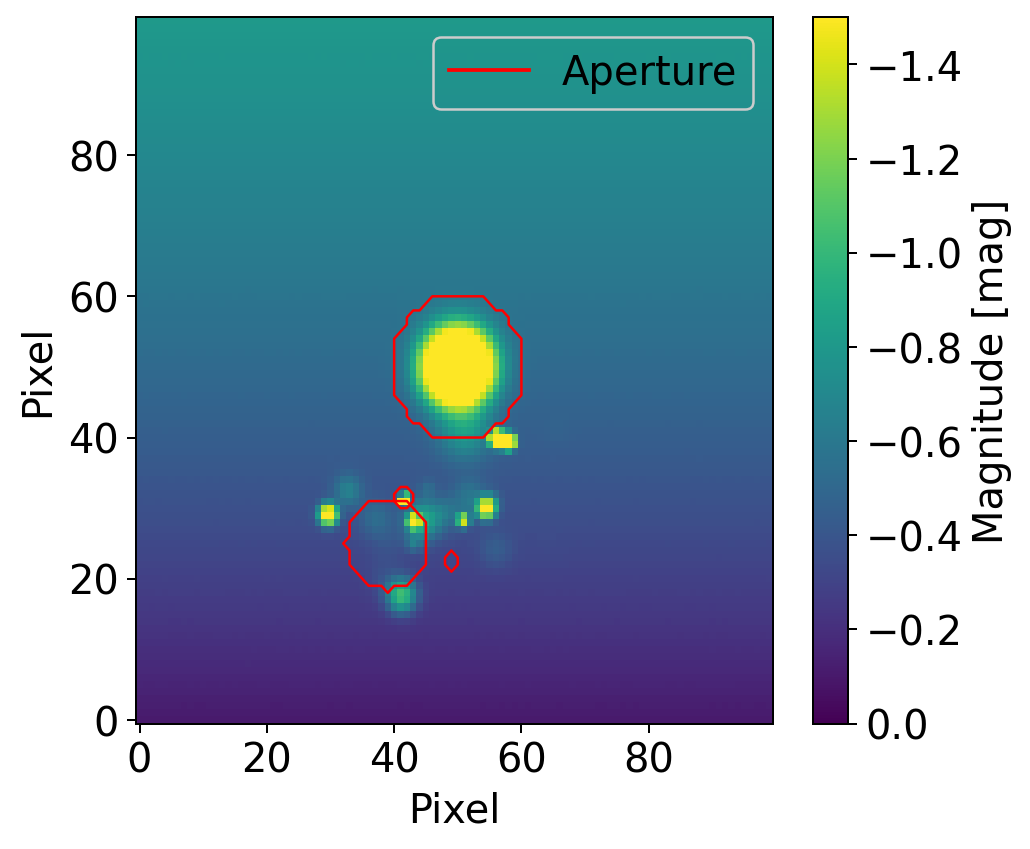

In [125]:
importlib.reload(alsi)

TPF = alsi.TPF(
    size=100,
    # mode='flux',
    mode='mag',
    f_ref=1, m_ref=0,
    store_stars=True,
    rng=None,
    verbose=0
)
print(TPF)

#random stars (distribution specified via list)
TPF.add_stars(
    nstars=30,
    posx={'dist':'chisquare', 'params':[50]},
    posy={'dist':'chisquare', 'params':[30]},
    # f={'dist':'uniform', 'params':[1,10]},
    m={'dist':'uniform', 'params':[-4,4]},
    aperture={'dist':'poisson', 'params':[5]},
)
#specified stars
TPF.add_stars(
    nstars=1,
    posx=np.array([50]),
    posy=np.array([50]),
    # f=np.array([500]),
    m=np.array([-7]),
    aperture=np.array([10]),
)

#custom (linear) trend
TPF.add_custom('lineary', amplitude=1)

#noise
TPF.add_noise(amplitude=5E-2, bias=1E-1)


#plot (including multiple apertures)
# fig, axs = TPF.plot_result(plot_apertures=range(-4,0,1))
fig, axs = TPF.plot_result(plot_apertures=range(-4,0,1), pcolormesh_kwargs=dict(vmin=-1.5, vmax=0))

try:
    print(f'Estimated Aperture: {TPF.aperture_from_mask(TPF.stars[-1,:,:,2]):.0f}')
except:
    pass
print(TPF.starparams[-1])

### Calculating total magnitude of all contaminants
* Weighted by distance to target star

In [70]:
importlib.reload(alpph)

#get target and contaminants
targ = TPF.starparams[-1]
cont = TPF.starparams[:-1]

#calculate distances
cont_pos = cont[:,:2]
dists = np.sqrt(np.sum((cont_pos - targ[:2])**2, axis=1))

#generate weights via distances
w = dists/dists.max()   #normalize distances to a max of

#calculate total magnitude of contaminants
cont_m = np.array([c[2] for c in cont])
cont_dm = np.random.uniform(0.1, 1, cont_m.shape[0])    #some random errors
m_tot, dm_tot = alpph.mags_sum(m=cont_m, w=w, dm=cont_dm, axis=None)
print(f'Total magnitude of contaminants: {m_tot:.5f} +/- {dm_tot:.5f} mag')


Total magnitude of contaminants: -2.34017 +/- 1.45015 mag


### Calculate fractional contribution of target star

In [62]:
importlib.reload(alpph)

print(targ[3])
m_cont_pre = alpph.mags_contribution(m=targ[3], m_cont=m_tot)       #using calculated total magnitude
m_cont_fly = alpph.mags_contribution(m=targ[3], m_cont=cont_m, w=w) #calculate total magnitude on the fly

print(f'Contribution of Target (precalculated): {m_cont_pre:.3f}')
print(f'Contribution of Target (on the fly):    {m_cont_fly:.3f}')


-7.000000000000001
Contribution of Target (precalculated): 0.987
Contribution of Target (on the fly):    0.987


For multiple targets at once

In [63]:
m_cont = alpph.mags_contribution(m=[targ[3],cont_m[0]], m_cont=cont_m[1:])
print(f'Contribution of Targets (precalculated): {m_cont}')

Contribution of Targets (precalculated): [0.98228117 0.07796083]


Will return 1 if no contaminants

In [64]:
m_nocont = alpph.mags_contribution(m=targ[3], m_cont=[])

print(f'Contribution of Target (no contaminant): {m_nocont:.3f}')

Contribution of Target (no contaminant): 1.000


### Pixel-Wise Total Flux

Generate a movie of stars (TPF series)

MovieWriter ffmpeg unavailable; using Pillow instead.


TPF_Series(
    size=(15, 15),
    mode='mag',
    f_ref=1, m_ref=0,
    rng='Generator',
    verbose=0,
)



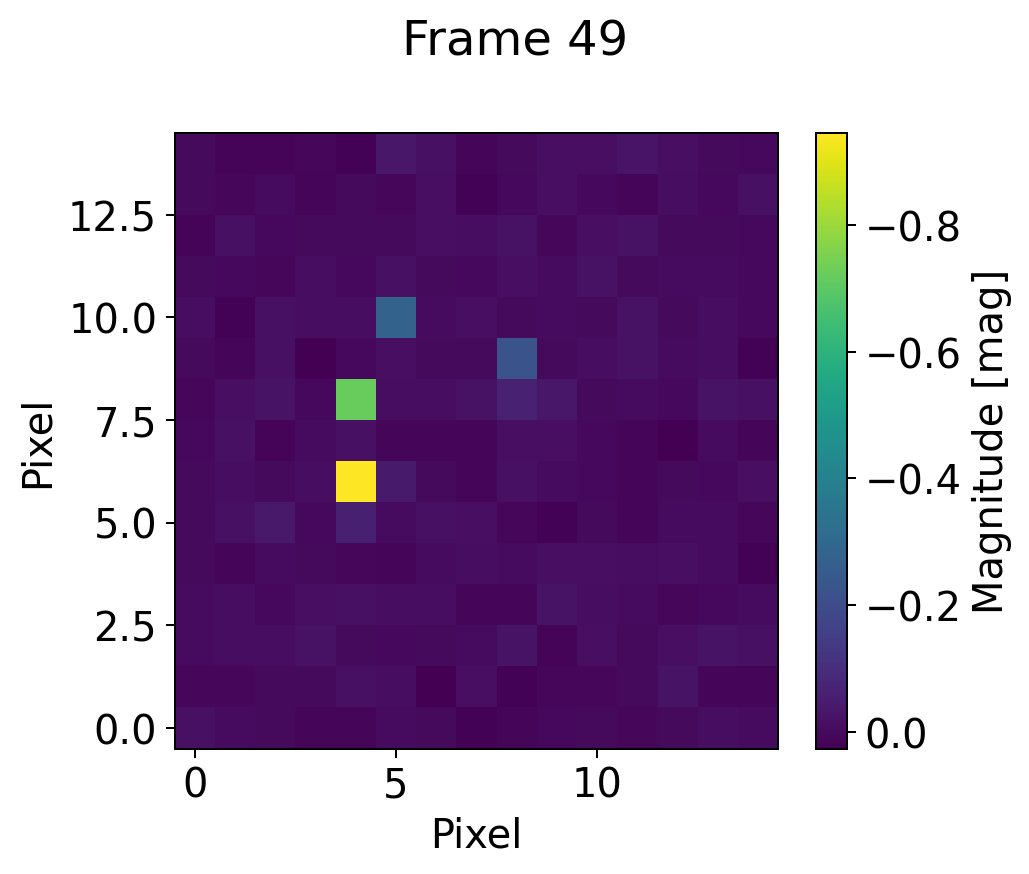

In [9]:
importlib.reload(alsi)

#define variability of magnitudes over time
def mf_var(tp, fm):
    period = 100
    amp    = 7
    rperiods = np.random.uniform(40, 50, size=fm[:-1].shape)
    ramps    = np.random.uniform(.1, 2,  size=rperiods.shape)
    
    fm[-1]  *= amp*(np.sin(2*np.pi*tp/period)+3) + 2E-3*np.random.randn(1)
    fm[:-1] *= ramps*(np.sin(2*np.pi*tp/rperiods)+2) + 1E-3*np.random.randn(*fm[:-1].shape)

    return fm

times = np.linspace(0,100,50)

TPFS = alsi.TPF_Series(
    size=15,
    # mode='flux',
    mode='mag',
    f_ref=1, m_ref=0,
    rng=None,
    verbose=0    
)
print(TPFS)

frames, starparams_s = TPFS.rvs(
    times=times,
    variability=mf_var,
    add_stars_kwargs=dict(
        nstars=5,
        m={'dist':'uniform', 'params':[-1,2]},
    ),
    add_noise_kwargs=dict(amplitude=1, bias=1),
    # add_custom_kwargs=dict(trend='linearx', amplitude=1.5),
)

fig, axs, anim = TPFS.plot_result(
    save='./test.gif',
    # pcolormesh_kwargs=dict(vmin=0, vmax=3),
)


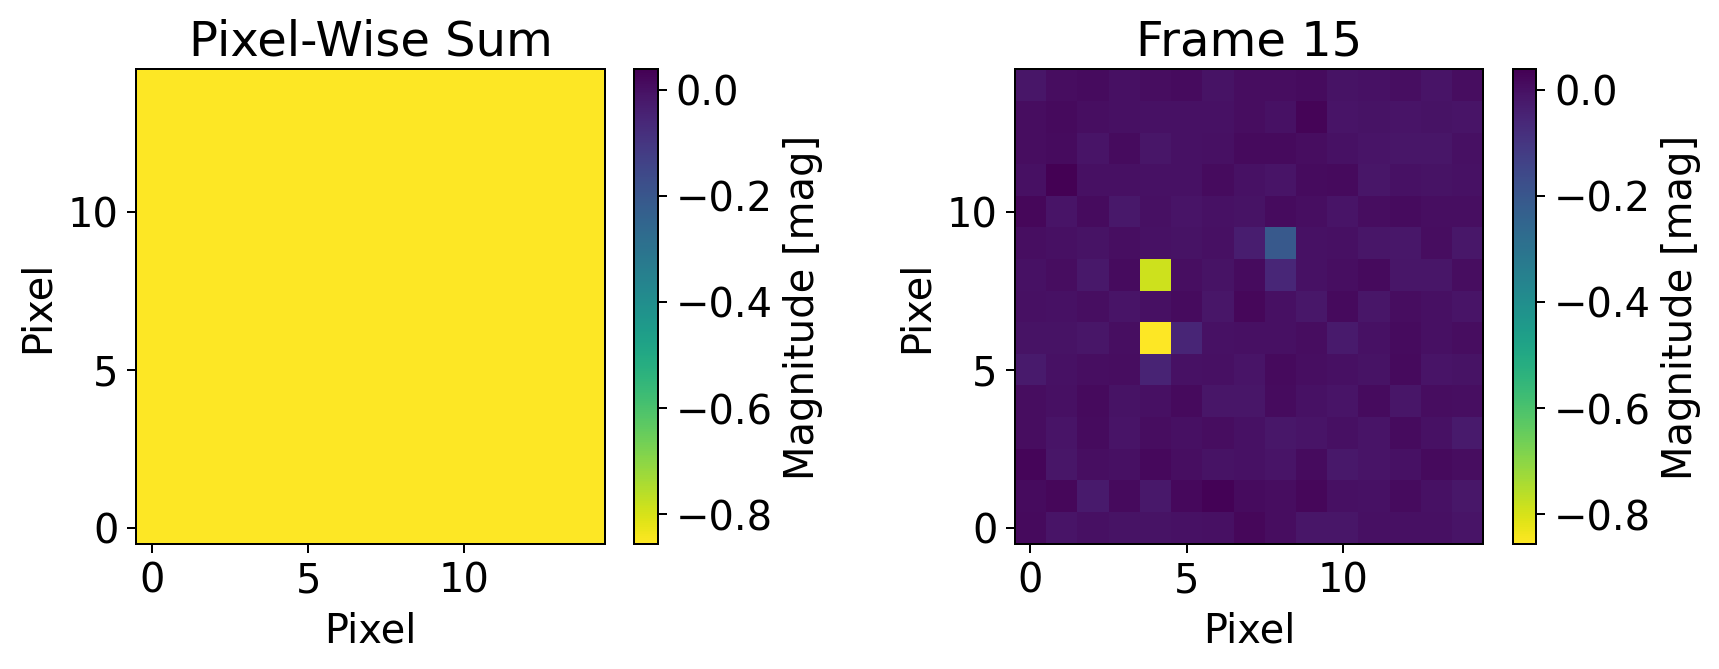

In [10]:

comparison_idx = 15

frame_sum = frames[0].copy()
frame_sum[:,:,2] = alpph.mags_sum(m=frames[:,:,:,2], w=None, axis=0)

vmin = frames[comparison_idx,:,:,2].min()
vmax = frames[comparison_idx,:,:,2].max()

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title(f'Pixel-Wise Sum')
ax2.set_title(f'Frame {comparison_idx}')
mesh1 = ax1.pcolormesh(frame_sum[:,:,0], frame_sum[:,:,1], frame_sum[:,:,2], vmin=vmin, vmax=vmax, cmap='viridis_r')
mesh2 = ax2.pcolormesh(frames[comparison_idx,:,:,0], frames[comparison_idx,:,:,1], frames[comparison_idx,:,:,2], vmin=vmin, vmax=vmax, cmap='viridis_r')

cbar1 = fig.colorbar(mesh1, ax=ax1)
cbar2 = fig.colorbar(mesh2, ax=ax2)

ax1.set_xlabel('Pixel')
ax2.set_xlabel('Pixel')
ax1.set_ylabel('Pixel')
ax2.set_ylabel('Pixel')
cbar1.set_label('Magnitude [mag]')
cbar2.set_label('Magnitude [mag]')
plt.show()

# Asteroseismic Scaling Relations

See for example [Gaulme et al., (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...832..121G/abstract) and references therein.

In [53]:
SR = alpas.ScalingRelations(
    nu_max  =np.array([3100,  1573, 1354]),
    delta_nu=np.array([135.2, 80.62, 73.22]),
    t_eff   =np.array([5777,  6433, 5645]),
    e_nu_max=np.array([np.nan, 11, 30]),
    e_delta_nu=np.array([np.nan, 1.88, 2.13]),
    e_t_eff=np.array([np.nan, 80, 80]),
    zeta_corr=False
)
print(SR)

mass = SR.get_mass()
radius = SR.get_radius()
logg = SR.get_logg()
logL = SR.get_luminosity()

df = SR.results2pandas()

df

ScalingRelations(
    nu_max=array([3100, 1573, 1354]), 
    delta_nu=array([135.2 ,  80.62,  73.22]), 
    t_eff=array([5777, 6433, 5645]), 
    e_nu_max=array([nan, 11., 30.]), e_delta_nu=array([ nan, 1.88, 2.13]), e_t_eff=array([nan, 80., 80.]), 
    nu_max_sun=3100, delta_nu_sun=135.2, t_eff_sun=5777, logg_sun=5777, 
    zeta_corr=False, 
)


,nu_max,e_nu_max,delta_nu,e_delta_nu,t_eff,e_t_eff,zeta_corr,mass_seism,e_mass_seism,radius_seism,e_radius_seism,luminosity_seism,e_luminosity_seism,logg_seism,e_logg_seism
0,3100.0,NaN,135.20,NaN,5777.0,NaN,0.0,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN
1,1573.0,11.0,80.62,1.88,6433.0,80.0,0.0,1.214237,0.118279,1.505880,0.071632,3.486788,0.393907,0.535455,0.009358
2,1354.0,30.0,73.22,2.13,5645.0,80.0,0.0,0.935624,0.126949,1.472081,0.092239,1.975649,0.283040,0.431755,0.023262
